In [1]:
import gdown
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import cv2
import math
import subprocess

# 1. Download do dataset

In [2]:
"""
Download das imagens e keypoints do dataset de um Drive utilizando o gdown
"""
images_id = "1Ge9jZppE9pGxqVyNAh6bWh4_ukffWBlF"
keypoints_id = "1bAidtvR3MttetncXz0mfr47vYy7Uf5hm"

gdown.download(f"https://drive.google.com/uc?id={images_id}", "images.zip")
gdown.download(f"https://drive.google.com/uc?id={keypoints_id}", "keypoints.json")

Downloading...
From (original): https://drive.google.com/uc?id=1Ge9jZppE9pGxqVyNAh6bWh4_ukffWBlF
From (redirected): https://drive.google.com/uc?id=1Ge9jZppE9pGxqVyNAh6bWh4_ukffWBlF&confirm=t&uuid=11466445-c369-4efd-a23b-29f8850d08fc
To: /content/images.zip
100%|██████████| 368M/368M [00:04<00:00, 75.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bAidtvR3MttetncXz0mfr47vYy7Uf5hm
To: /content/keypoints.json
100%|██████████| 2.36M/2.36M [00:00<00:00, 16.9MB/s]


'keypoints.json'

In [3]:
"""
    Extraindo as imagens do arquivo zip
"""
from zipfile import ZipFile
with ZipFile("/content/images.zip", 'r') as zObject:
    zObject.extractall(
        path="/content/images")

# 2. Análise Exploratória

## 2.1 Preparação de variáveis para análise

In [4]:
# Abrindo o arquivo de keypoints
f = open("/content/keypoints.json")
keypoints = json.load(f)
f.close()

In [5]:
# Criando um dicionário de categorias a partir de informações do json
categories = {}
categories_json = keypoints['categories']

for category in categories_json:
  categories[category['id']] = category['name']

categories

{1: 'dog', 2: 'cat', 3: 'sheep', 4: 'horse', 5: 'cow'}

In [6]:
# Calculando a ocorrência de cada categoria
categories_occ = np.zeros(len(categories))

for annotation in keypoints['annotations']:
  categories_occ[annotation['category_id'] - 1] += 1

categories_occ

array([1771., 1466., 1078.,  960.,  842.])

In [7]:
"""
  Obtendo as imagens únicas de cada categoria
"""

dog_imgs = []
cat_imgs = []
sheep_imgs = []
horse_imgs = []
cow_imgs = []

cow_annotations = {}

for annotation in keypoints['annotations']:
  animal_id = annotation['category_id']
  animal_img_id = str(annotation['image_id'])
  if animal_id == 1:
    dog_img = keypoints['images'][animal_img_id]
    dog_imgs.append(dog_img)
  if animal_id == 2:
    cat_img = keypoints['images'][animal_img_id]
    cat_imgs.append(cat_img)
  if animal_id == 3:
    sheep_img = keypoints['images'][animal_img_id]
    sheep_imgs.append(sheep_img)
  if animal_id == 4:
    horse_img = keypoints['images'][animal_img_id]
    horse_imgs.append(horse_img)
  if animal_id == 5:
    cow_img = keypoints['images'][animal_img_id]
    cow_imgs.append(cow_img)
    cow_annotations[cow_img] = annotation

unique_imgs = np.zeros(len(categories))
unique_imgs[0] = len(np.unique(dog_imgs))
unique_imgs[1] = len(np.unique(cat_imgs))
unique_imgs[2] = len(np.unique(sheep_imgs))
unique_imgs[3] = len(np.unique(horse_imgs))
unique_imgs[4] = len(np.unique(cow_imgs))

In [8]:
"""
    Obtendo as dimensões das imagens e suas ocorrências
"""

root_dir = "/content/images/images/"
dimensions = []
dimensions_count = []

for i in range(len(keypoints['images'])):
  image = keypoints['images'][str(i + 1)]
  img = Image.open(root_dir + image)
  width, height = img.size
  dimension = f"{width}x{height}"

  if dimension in dimensions:
      id = dimensions.index(dimension)
      dimensions_count[id] += 1
  else:
      dimensions.append(dimension)
      dimensions_count.append(1)

print(dimensions)
print(dimensions_count)

['500x375', '500x332', '500x333', '375x500', '500x334', '500x412', '480x437', '500x441', '318x480', '500x353', '500x328', '387x500', '429x500', '333x500', '480x398', '275x315', '500x500', '500x340', '500x397', '500x324', '458x500', '368x500', '329x500', '454x500', '320x212', '480x423', '360x500', '417x500', '500x384', '372x500', '500x442', '500x314', '500x376', '500x358', '457x500', '354x500', '264x499', '500x315', '494x500', '500x281', '500x446', '480x318', '500x389', '400x253', '500x374', '480x360', '500x388', '480x367', '500x322', '500x402', '500x349', '299x500', '500x345', '334x500', '500x371', '500x344', '443x480', '500x320', '500x316', '480x392', '496x500', '182x250', '500x302', '500x469', '500x269', '378x500', '332x500', '499x500', '500x400', '356x480', '459x500', '500x319', '357x500', '360x270', '500x321', '480x272', '448x336', '493x500', '483x500', '500x351', '500x370', '500x357', '500x466', '486x348', '411x500', '258x500', '500x346', '500x360', '500x292', '500x347', '500x310'

## 2.2 Análise de quantidade de imagens por categoria

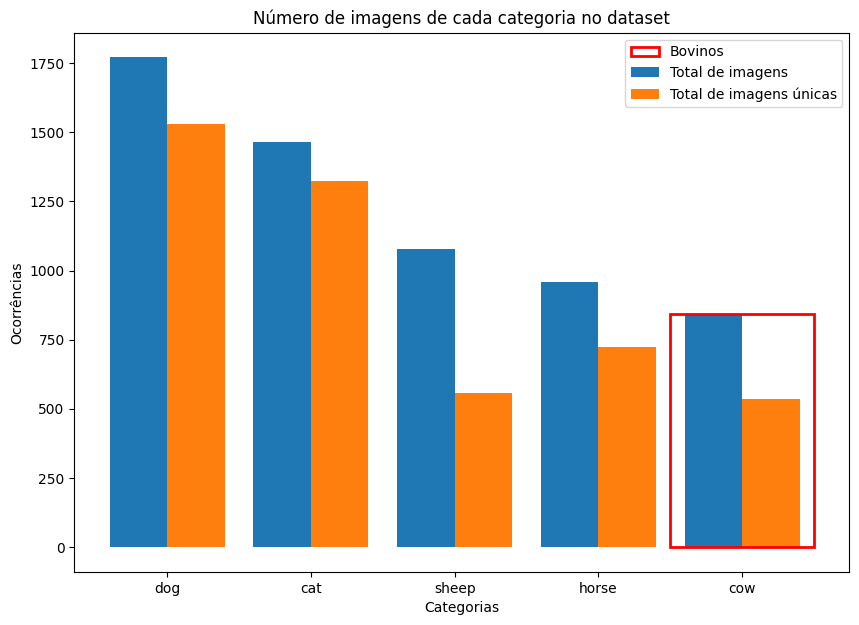

Total de imagens:  6117.0
Total de imagens únicas:  4666.0


Total de imagens de bovinos:  842
Total de imagens únicas de bovinos:  534


In [9]:
"""
    Plotando o gráfico de quantidade de imagens por categoria
"""
import matplotlib.patches as patches

# Gráfico de ocorrências
labels = [categories[i+1] for i in range(len(categories))]
values = categories_occ

X_axis = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10, 7))

bars1 = ax.bar(X_axis - 0.2, values, 0.4, label = 'Total de imagens')
bars2 = ax.bar(X_axis + 0.2, unique_imgs, 0.4, label = 'Total de imagens únicas')

last_cow_idx = len(labels) - 1

bars1_coords = bars1[last_cow_idx].get_bbox()
bars2_coords = bars2[last_cow_idx].get_bbox()

padding = 0.1

# Cria um retângulo em volta das barras de bovinos
bbox = patches.Rectangle((bars1_coords.x0 - padding, min(bars1_coords.y0, bars2_coords.y0) - padding),
                         bars2_coords.x1 - bars1_coords.x0 + 2 * padding,
                         max(bars1_coords.y1, bars2_coords.y1) - min(bars1_coords.y0, bars2_coords.y0) + 2 * padding,
                         linewidth=2, edgecolor='red', facecolor='none', label="Bovinos")

ax.add_patch(bbox)

plt.xticks(X_axis, labels)
plt.xlabel('Categorias')
plt.ylabel('Ocorrências')
plt.title('Número de imagens de cada categoria no dataset')
plt.legend()
plt.show()

print("Total de imagens: ", sum(values))
print("Total de imagens únicas: ", sum(unique_imgs))

print("\n")

print("Total de imagens de bovinos: ", len(cow_imgs))
print("Total de imagens únicas de bovinos: ", len(np.unique(cow_imgs)))

## 2.3 Análise de dimensões das imagens do dataset

### 2.3.1 Todo o dataset

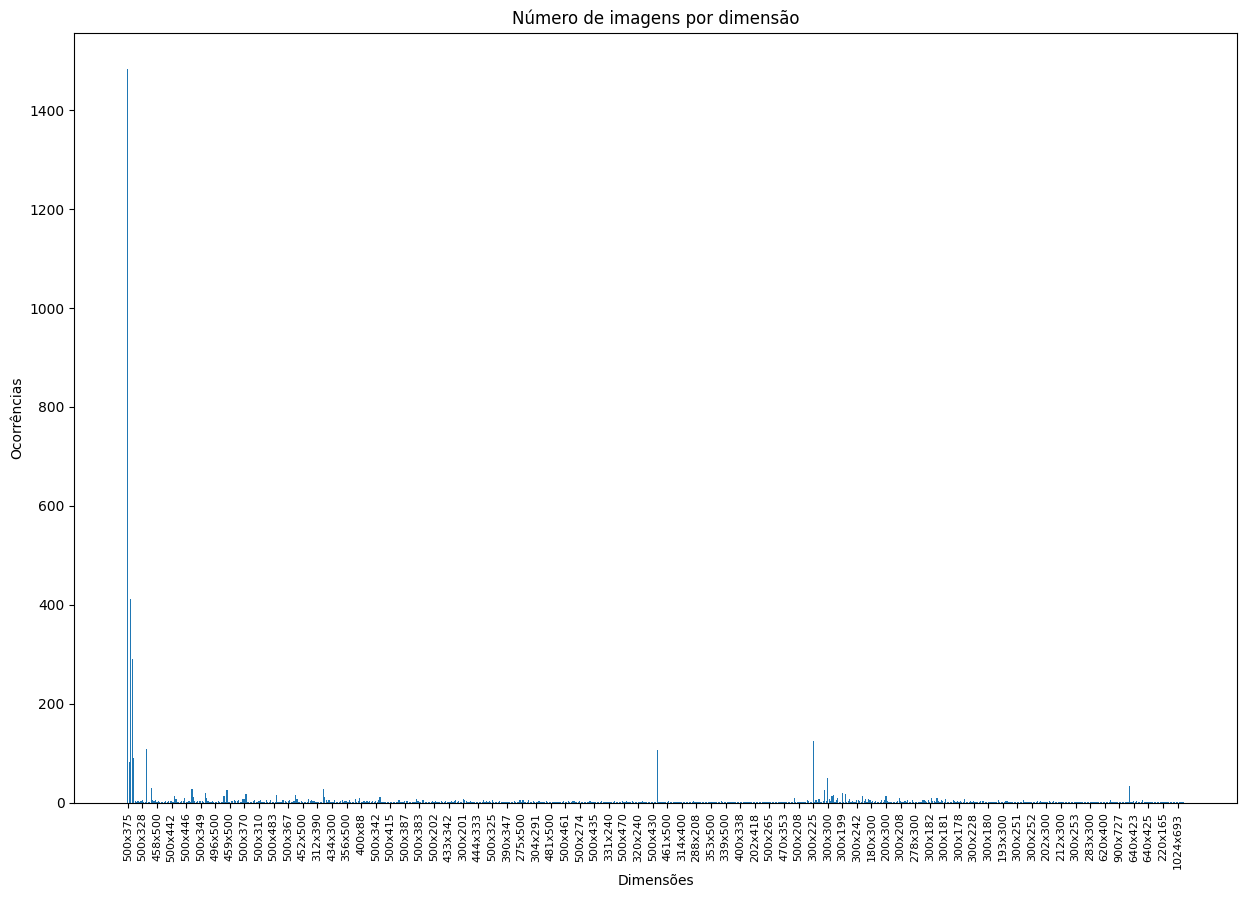

32.161458333333336% das imagens possui dimensão 500x375, sendo a com mais imagens.


In [10]:
"""
    Plotando o gráfico de quantidade de imagens por dimensão de todo o dataset
"""

fig, ax = plt.subplots(figsize=(15, 10))
bars = ax.bar(dimensions, dimensions_count)

ax.set_xlabel('Dimensões')
ax.set_ylabel('Ocorrências')
ax.set_title('Número de imagens por dimensão')
plt.xticks(rotation=90, fontsize=8)

# Limitando o número de labels no eixo x para melhor visualização (a cada 10)
ax.set_xticks(ax.get_xticks()[::10])

plt.show()

print(str(100 * dimensions_count[0] / sum(dimensions_count)) + "% das imagens possui dimensão " + dimensions[0] + ", sendo a com mais imagens.")

### 2.3.2 Apenas imagens de bovinos

In [11]:
"""
    Obtendo as dimensões das imagens de bovinos e suas ocorrências
"""

cow_dimensions = []
cow_dimensions_count = []

for i in range(len(cow_imgs)):
  image = cow_imgs[i]
  img = Image.open(root_dir + image)
  width, height = img.size
  dimension = f"{width}x{height}"

  if dimension in cow_dimensions:
      id = cow_dimensions.index(dimension)
      cow_dimensions_count[id] += 1
  else:
      cow_dimensions.append(dimension)
      cow_dimensions_count.append(1)

print(cow_dimensions)
print(cow_dimensions_count)

['375x500', '500x334', '500x412', '500x375', '429x500', '500x397', '500x332', '500x314', '500x376', '500x315', '500x446', '480x360', '500x388', '500x322', '500x324', '500x316', '500x333', '500x351', '500x292', '500x400', '332x500', '500x338', '500x358', '500x206', '500x381', '500x335', '500x396', '448x299', '500x371', '500x336', '347x500', '500x377', '374x500', '474x500', '500x300', '481x500', '500x352', '216x288', '500x330', '500x404', '333x500', '281x500', '334x500', '500x342', '500x370', '500x373', '500x339', '500x272', '500x363', '500x252', '500x365', '500x357', '500x500', '326x500', '441x500', '362x500', '500x407', '500x308', '500x340', '500x244', '500x405', '500x390', '500x417', '450x338', '500x418', '353x500', '350x500', '500x249', '500x283', '500x361', '500x420', '432x463', '370x500', '500x274', '500x281', '500x356', '500x364', '257x171', '500x273', '500x355', '500x327', '500x378', '500x306', '448x336', '500x309', '500x354', '500x389', '500x331', '500x374', '500x208', '300x225'

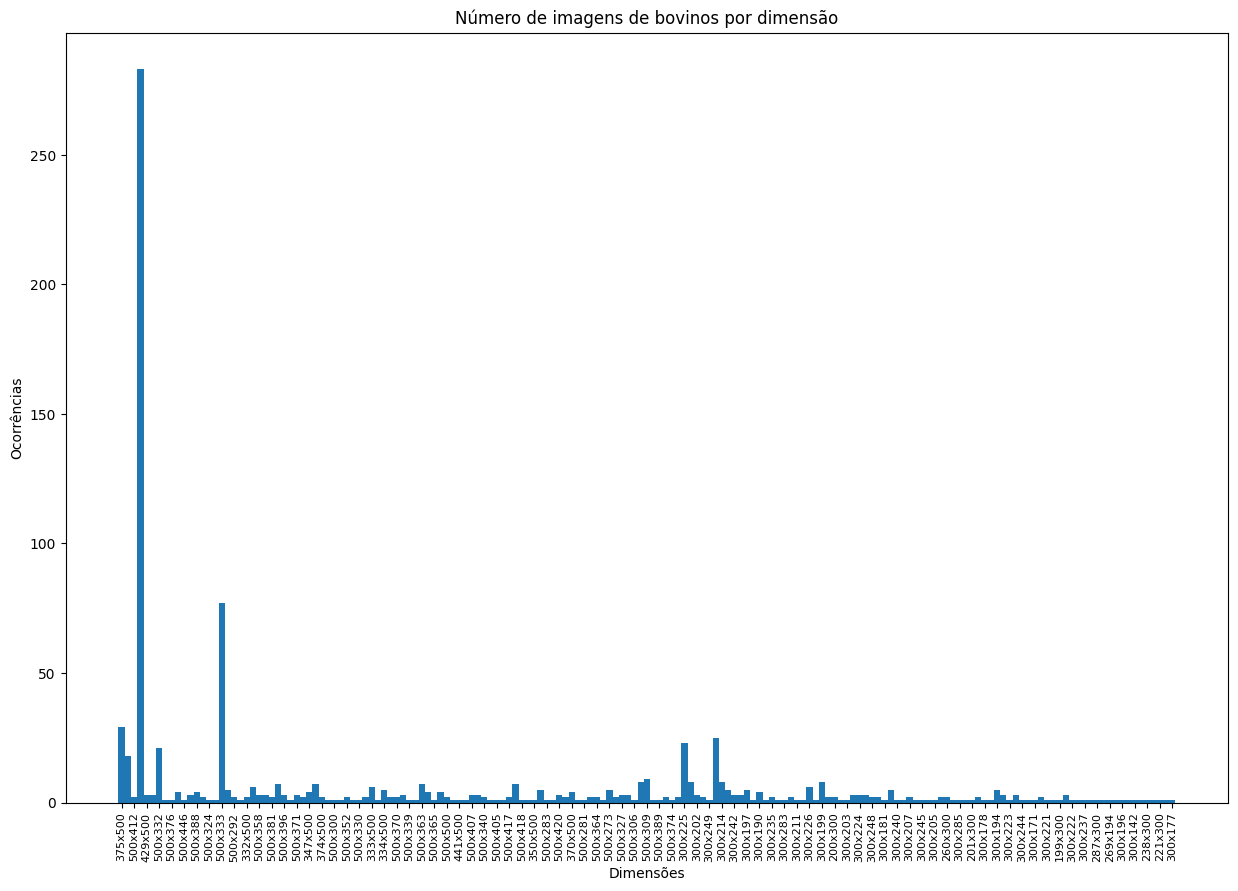

33.6104513064133% das imagens possui dimensão 500x375, sendo a com mais imagens.


In [12]:
"""
    Plotando o gráfico de quantidade de imagens por dimensão de bovinos
"""

fig, ax = plt.subplots(figsize=(15, 10))
bars = ax.bar(cow_dimensions, cow_dimensions_count, width=1)

ax.set_xlabel('Dimensões')
ax.set_ylabel('Ocorrências')
ax.set_title('Número de imagens de bovinos por dimensão')
plt.xticks(rotation=90, fontsize=8)

# Limitando o número de labels no eixo x para melhor visualização (a cada 2)
ax.set_xticks(ax.get_xticks()[::2])

plt.show()

max_id = cow_dimensions_count.index(max(cow_dimensions_count))
print(str(100 * max(cow_dimensions_count) / sum(cow_dimensions_count)) + "% das imagens possui dimensão " + cow_dimensions[max_id] + ", sendo a com mais imagens.")

# 3. Processamento

In [13]:
def load_image_and_annotations(image_path, annotations):
    """ Carrega uma imagem e suas anotações

    Args:
        image_path (str): caminho da imagem
        annotations (dict): dicionário de anotações da imagem

    Returns:
        tuple: imagem e keypoints
    """
    image = cv2.imread(image_path)
    annotation = annotations[os.path.basename(image_path)]
    keypoints = annotation['keypoints']
    return image, keypoints

In [14]:
def resize_image(image, keypoints):
    """ Redimensiona uma imagem e seus keypoints
    
    Args:
        image (numpy.ndarray): imagem
        keypoints (list): lista de keypoints
        
    Returns:
        tuple: imagem redimensionada e keypoints redimensionados
    """
    
    h, w, _ = image.shape
    if h < w:
        new_w = DESIRED_WIDTH
        new_h = math.floor(h * DESIRED_WIDTH / w)
    else:
        new_h = DESIRED_HEIGHT
        new_w = math.floor(w * DESIRED_HEIGHT / h)

    scale_x = new_w / w
    scale_y = new_h / h
    image_resized = cv2.resize(image, (new_w, new_h))

    keypoints_resized = []
    for point in keypoints:
        x, y, v = point
        x_new = x * scale_x
        y_new = y * scale_y
        keypoints_resized.append([x_new, y_new, v])

    return image_resized, keypoints_resized

In [15]:
def normalize_image(image):
    """ Normaliza uma imagem para o intervalo [0, 1]
    
    Args:
        image (numpy.ndarray): imagem
        
    Returns:
        numpy.ndarray: imagem normalizada
    
    """
    image_normalized = image / 255.0
    return image_normalized

In [16]:
def visualize_image(image, keypoints):
    """
    Visualiza uma imagem com seus keypoints
    
    Args:
        image (numpy.ndarray): imagem
        keypoints (list): lista de keypoints
    
    """
    image_uint8 = (image * 255).astype(np.uint8)
    plt.imshow(cv2.cvtColor(image_uint8, cv2.COLOR_BGR2RGB))
    for point in keypoints:
        x, y, v = point
        if v > 0:  # Apenas visualize pontos válidos
            plt.scatter(x, y, c='red', marker='x')
    plt.show()

In [17]:
def augment_image(image, keypoints):
    """ Realiza uma rotação de 30 graus na imagem e keypoints

    Args:
        image (np.ndarray): imagem
        keypoints (list): lista de keypoints

    Returns:
        tuple: imagem rotacionada e keypoints rotacionados
    """
    h, w, _ = image.shape
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, 30, 1.0)
    image_rotated = cv2.warpAffine(image, matrix, (w, h))

    keypoints_rotated = []
    for point in keypoints:
        x, y, v = point
        x_new = matrix[0, 0] * x + matrix[0, 1] * y + matrix[0, 2]
        y_new = matrix[1, 0] * x + matrix[1, 1] * y + matrix[1, 2]
        keypoints_rotated.append([x_new, y_new, v])

    return image_rotated, keypoints_rotated

In [18]:
def create_processing_figure(original, resized, normalized, augmented, original_ann, resized_ann, augmented_ann):
    """
    Cria uma figura com 4 subplots para visualização do processamento da imagem
    
    Args:
        original (numpy.ndarray): imagem original
        resized (numpy.ndarray): imagem redimensionada
        normalized (numpy.ndarray): imagem normalizada
        augmented (numpy.ndarray): imagem rotacionada
        original_ann (list): keypoints da imagem original
        resized_ann (list): keypoints da imagem redimensionada
        augmented_ann (list): keypoints da imagem rotacionada
    """
    normalized_uint8 = (normalized * 255).astype(np.uint8)
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f'Original\n{original.shape}')
    for point in original_ann:
        x, y, v = point
        if v > 0:
            axs[0].scatter(x, y, c='red', marker='x')

    axs[1].imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    axs[1].set_title(f'Redimensionada\n{resized.shape}')
    for point in resized_ann:
        x, y, v = point
        if v > 0:
            axs[1].scatter(x, y, c='red', marker='x')

    augmented_uint8 = (augmented * 255).astype(np.uint8)
    axs[2].imshow(cv2.cvtColor(augmented_uint8, cv2.COLOR_BGR2RGB))
    axs[2].set_title('Augmentada')
    for point in augmented_ann:
        x, y, v = point
        if v > 0:
            axs[2].scatter(x, y, c='red', marker='x')

    axs[3].imshow(normalized_uint8)
    axs[3].set_title('Normalizada')

    plt.show()

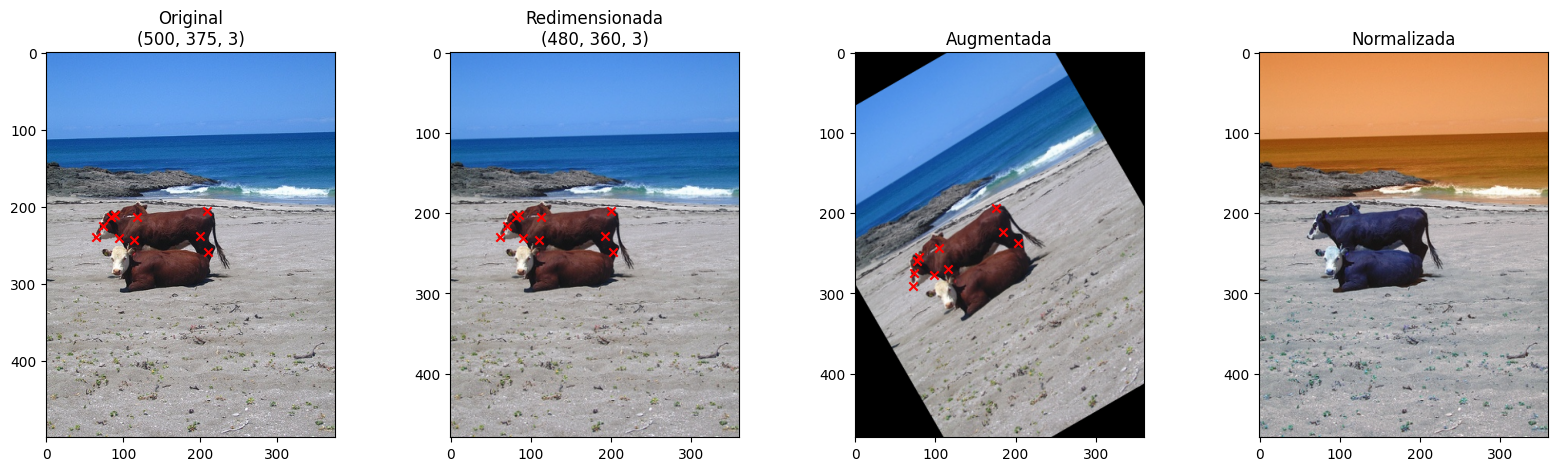

In [19]:
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

images_list = []
keypoints_list = []
types_list = []
added_imgs_list = []
dimensions_list = []

counter = 0
for img in np.unique(cow_imgs):
  image_file = img
  annotation_file = cow_annotations[image_file]

  # Carregando imagem e anotações
  image, keypoints = load_image_and_annotations(root_dir + image_file, cow_annotations)

  image_resized, keypoints_resized = resize_image(image, keypoints)
  image_normalized = normalize_image(image_resized)
  image_augmented, keypoints_augmented = augment_image(image_normalized, keypoints_resized)

  images_list.append(image_resized / 255)
  keypoints_list.append(keypoints_resized)
  types_list.append('resized')
  added_imgs_list.append(img)
  dimensions_list.append(image_resized.shape[:2])

  images_list.append(image_augmented)
  keypoints_list.append(keypoints_augmented)
  types_list.append('augmented')
  added_imgs_list.append(img)
  dimensions_list.append(image_augmented.shape[:2])

  # Criação da figura ilustrativa do processo
  if counter < 1:
    create_processing_figure(image, image_resized, image_normalized, image_augmented, keypoints, keypoints_resized, keypoints_augmented)

  counter += 1


In [20]:
# Criando o DataFrame
df = pd.DataFrame({
    'image_name': added_imgs_list,
    'image': images_list,
    'keypoints': keypoints_list,
    'type': types_list,
    'dimensions': dimensions_list
})

# Exibindo o DataFrame
df

,image_name,image,keypoints,type,dimensions
0,2007_000464.jpg,"[[[0.8666666666666667, 0.5254901960784314, 0.2...","[[70.08, 216.0, 1], [0.0, 0.0, 0], [61.44, 230...",resized,"(480, 360)"
1,2007_000464.jpg,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[72.8064876160145, 274.17539030917345, 1], [-...",augmented,"(480, 360)"
2,2007_000491.jpg,"[[[0.0196078431372549, 0.00784313725490196, 0....","[[0.0, 0.0, 0], [244.79999999999998, 44.071856...",resized,"(320, 480)"
3,2007_000491.jpg,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[-47.846096908265274, 141.4359353944898, 0], ...",augmented,"(320, 480)"
4,2007_000504.jpg,"[[[0.1568627450980392, 0.1843137254901961, 0.1...","[[348.47999999999996, 119.84223300970874, 1], ...",resized,"(395, 480)"
...,...,...,...,...,...
1063,co97.jpeg,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[263.0389542409204, 30.3046392985286, 1], [-4...",augmented,"(320, 480)"
1064,co98.jpeg,"[[[0.8941176470588236, 0.9490196078431372, 0.9...","[[75.2, 67.15254237288136, 1], [0.0, 0.0, 0], ...",resized,"(283, 480)"
1065,co98.jpeg,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[60.35528464276519, 159.44622569002033, 1], [...",augmented,"(283, 480)"
1066,co99.jpeg,"[[[0.9294117647058824, 0.7843137254901961, 0.6...","[[132.8, 155.20000000000002, 1], [96.0, 155.20...",resized,"(480, 480)"


In [21]:
!rm -r -f /content/bovinos_images

In [22]:
destination_dir = '/content/bovinos_images'
os.makedirs(destination_dir, exist_ok=True)

# Função para salvar as imagens do DataFrame em outro diretório
def save_images_from_dataframe(df, destination_dir):
    for idx, row in df.iterrows():
        if row['type'] == 'resized':
          image = row['image'] * 255
          image_name = row['image_name']
          destination_path = os.path.join(destination_dir, image_name)
          # Salvar a imagem
          cv2.imwrite(destination_path, image)
          print(f'Saved {image_name} to {destination_path}')

# Salvar as imagens do DataFrame
save_images_from_dataframe(df, destination_dir)

Saved 2007_000464.jpg to /content/bovinos_images/2007_000464.jpg
Saved 2007_000491.jpg to /content/bovinos_images/2007_000491.jpg
Saved 2007_000504.jpg to /content/bovinos_images/2007_000504.jpg
Saved 2007_000904.jpg to /content/bovinos_images/2007_000904.jpg
Saved 2007_001073.jpg to /content/bovinos_images/2007_001073.jpg
Saved 2007_001299.jpg to /content/bovinos_images/2007_001299.jpg
Saved 2007_001764.jpg to /content/bovinos_images/2007_001764.jpg
Saved 2007_001917.jpg to /content/bovinos_images/2007_001917.jpg
Saved 2007_002088.jpg to /content/bovinos_images/2007_002088.jpg
Saved 2007_002387.jpg to /content/bovinos_images/2007_002387.jpg
Saved 2007_002669.jpg to /content/bovinos_images/2007_002669.jpg
Saved 2007_002789.jpg to /content/bovinos_images/2007_002789.jpg
Saved 2007_002903.jpg to /content/bovinos_images/2007_002903.jpg
Saved 2007_003201.jpg to /content/bovinos_images/2007_003201.jpg
Saved 2007_003841.jpg to /content/bovinos_images/2007_003841.jpg
Saved 2007_004081.jpg to 

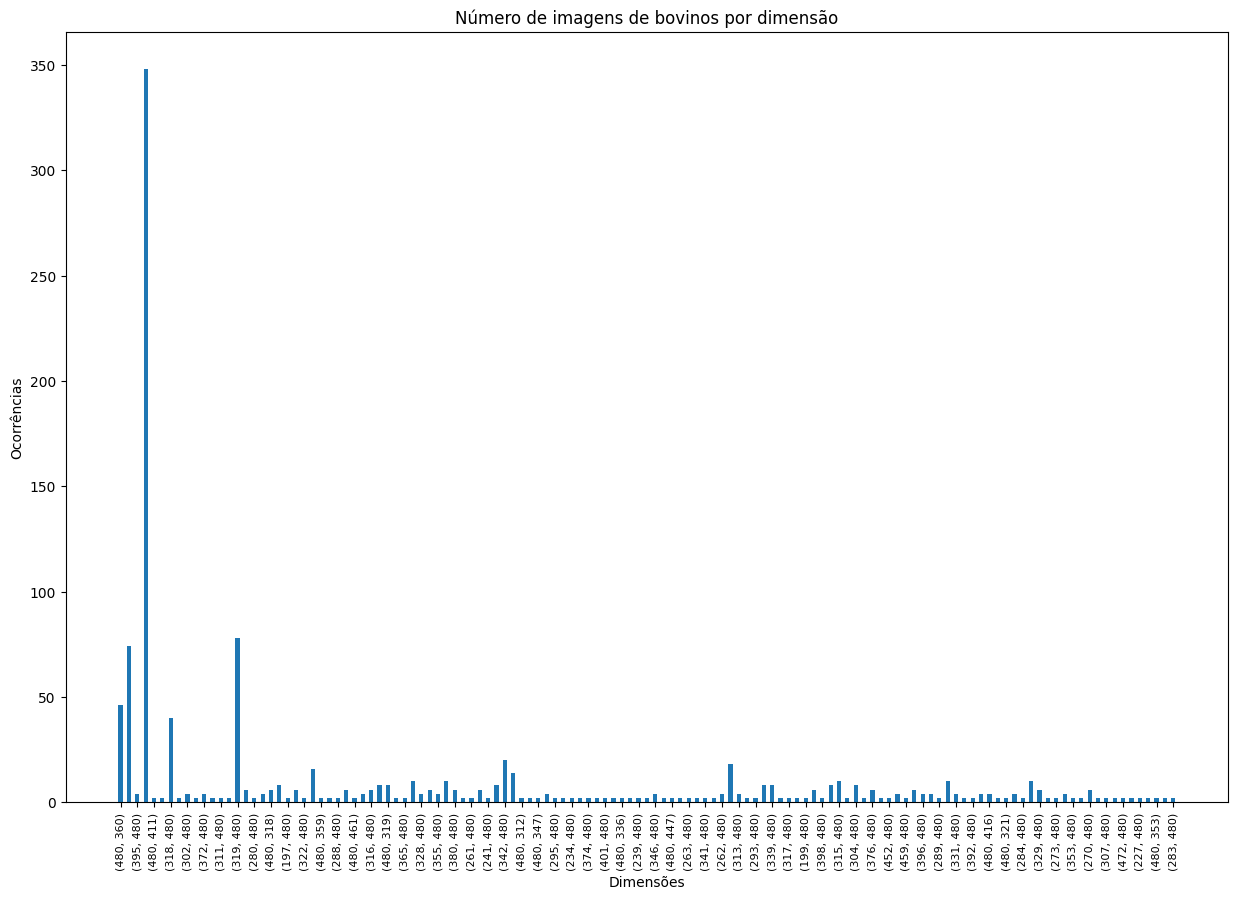

In [23]:
from collections import Counter
dimensions_counter = Counter(df['dimensions'])

# Extraindo as dimensões e contagens
cow_proccessed_dimensions = list(dimensions_counter.keys())
cow_proccessed_dimensions_count = list(dimensions_counter.values())

# Plotando as dimensões das imagens
fig, ax = plt.subplots(figsize=(15, 10))
bars = ax.bar(range(len(cow_proccessed_dimensions)), cow_proccessed_dimensions_count, width=0.5)

# Ajustar os rótulos do eixo x para melhor legibilidade
ax.set_xlabel('Dimensões')
ax.set_ylabel('Ocorrências')
ax.set_title('Número de imagens de bovinos por dimensão')
plt.xticks(range(len(cow_proccessed_dimensions)), cow_proccessed_dimensions, rotation=90, fontsize=8)

# Opcional: limitar o número de rótulos
ax.set_xticks(ax.get_xticks()[::2])

plt.show()

In [24]:
print(len(cow_dimensions))
print(len(cow_proccessed_dimensions))

169
127


# 4. Pose Estimation

In [25]:
!rm -f -r util
!rm -f animalpose.py
!rm -f animalpose_utils.py

In [26]:
!pip install ailia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 11.6 MB/s eta 0:00:00


In [27]:
import os
import ailia

model_dir = "animalpose_model"
os.makedirs(model_dir, exist_ok=True)

# Donwload do modelo de animal pose estimation da Ailia
!wget -q https://storage.googleapis.com/ailia-models/animalpose/hrnet_w32_256x256.onnx -O {model_dir}/hrnet_w32_256x256.onnx
!wget -q https://storage.googleapis.com/ailia-models/animalpose/hrnet_w32_256x256.onnx.prototxt -O {model_dir}/hrnet_w32_256x256.onnx.prototxt

# Download do arquivo principal
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/pose_estimation/animalpose/animalpose.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/pose_estimation/animalpose/animalpose_utils.py

# Download de arquivos utilitários
os.makedirs('util', exist_ok=True)

!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/arg_utils.py -O util/arg_utils.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/model_utils.py -O util/model_utils.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/image_utils.py -O util/image_utils.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/detector_utils.py -O util/detector_utils.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/webcamera_utils.py -O util/webcamera_utils.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/params.py -O util/params.py
!wget -q https://raw.githubusercontent.com/axinc-ai/ailia-models/master/util/log_init.py -O util/log_init.py

In [28]:
def predict_pose(image_path):
    """
    Executa a predição de pose em uma imagem
    
    Args:
        image_path (str): caminho da imagem
    """
    print(image_path)
    !rm -f animalpose_modified.py
    !rm -f hrnet_w32_256x256.onnx
    !rm -f hrnet_w32_256x256.onnx.prototxt
    !rm -f output_result.png
    !rm -f yolov3.opt2.onnx
    !rm -f yolov3.opt2.onnx.prototxt

    with open('animalpose.py', 'r') as file:
        script_content = file.read()

    # Modificar o script para usar a imagem de entrada e salvar a imagem de saída
    script_content = script_content.replace('input.jpg', image_path).replace('output.png', 'output_result.png')

    # Adicionar informações de debug para verificar se a imagem é lida corretamente
    script_content = script_content.replace(
        "IMAGE_PATH = args.input",
        f"IMAGE_PATH = '{image_path}'\nprint('Using image:', IMAGE_PATH)"
    )

    # Garantir que o script possa encontrar os arquivos util
    script_content = script_content.replace("sys.path.append('../../util')", "sys.path.append('./util')")

    with open('animalpose_modified.py', 'w') as file:
        file.write(script_content)

    # Executa o script modificado
    result = subprocess.run(['python3', 'animalpose_modified.py'], capture_output=True, text=True)

    # Checar se a imagem de saída foi salva corretamente
    if os.path.exists('output_result.png'):
        output_image = cv2.imread('output_result.png')
        output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

        # Display da imagem com os keypoints
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()
    else:
        print("Output image not found. Check the script for errors.")

/content/bovinos_images/2007_000464.jpg


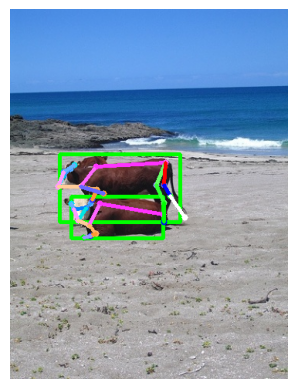

In [29]:
image_dir = "/content/bovinos_images/"
predict_pose(image_dir + df['image_name'].iloc[0])

/content/bovinos_images/2008_005105.jpg


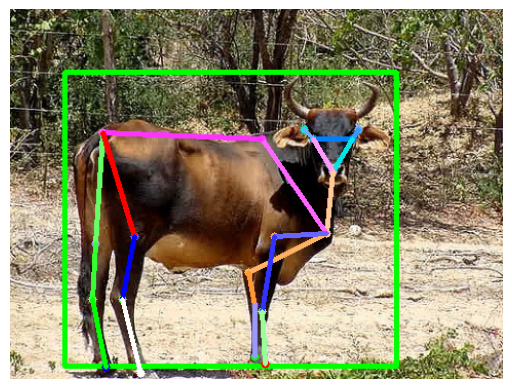

/content/bovinos_images/co10.jpeg


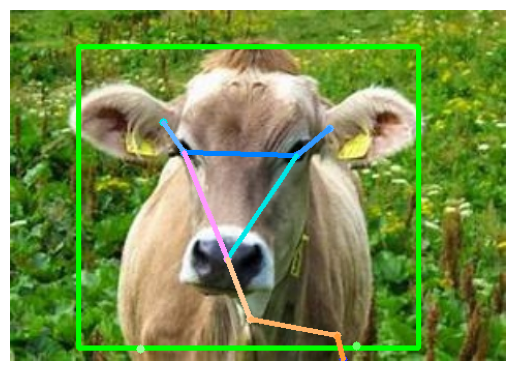

/content/bovinos_images/co123.jpeg


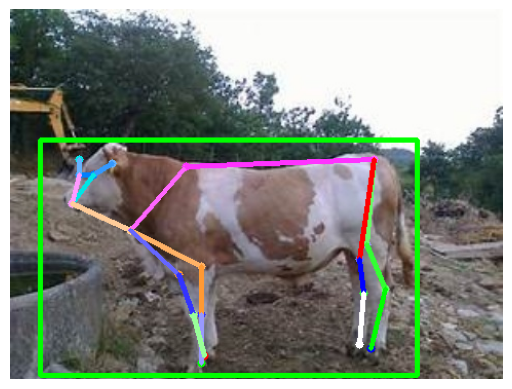

/content/bovinos_images/2008_000009.jpg


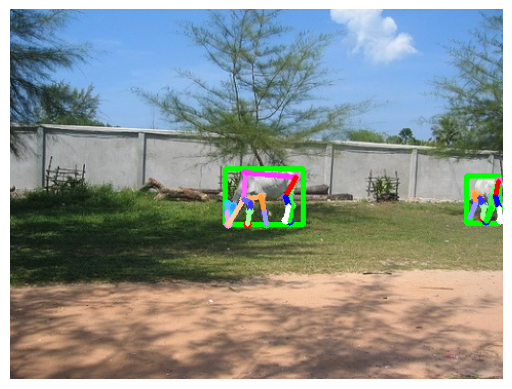

/content/bovinos_images/co87.jpeg


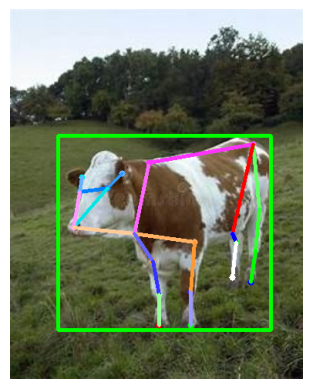

In [30]:
image_dir = "/content/bovinos_images/"

# Predição de 5 imagens
for root, dirs, files in os.walk(image_dir):
  for i in range(0, 5):
    predict_pose(image_dir + files[i])